# **Pendahuluan**


## ***Tujuan Kompetisi***


Objektif dari kompetisi ini adalah untuk mengembangkan model machine learning untuk deteksi fraud pada pengguna platform fintech. Segala metode machine learning, matematis, dan statistik dapat digunakan untuk meningkatkan performa dari model yang dipakai. Selain mengembangkan model klasifikasi, kemampuan analisis mengenai pola pengguna yang teridentifikasi sebagai fraud juga diperlukan untuk menjelaskan cara kerja model yang dipakai.

## ***Apa itu Fraud Detection?***

Fraud detection adalah proses identifikasi tindakan pengguna pada suatu skenario termasuk sebagai tindakan penipuan atau bukan. Dalam konteks kompetisi ini, tindakan penipuan didefinisikan sebagai pengguna platform yang telah meminjam produk keuangan tetapi tercatat belum melakukan pembayaran sampai tenggat waktu yang telah ditentukan.

## ***Evaluasi***

Performa model dievaluasi menggunakan metrik Average Precision dengan average='macro'. Secara formal, metrik Average Precision dirumuskan dalam bentuk:

$$\text{Average Precision} = \sum_i \left( Recall_i + Recall_{i-1} \right)Precision_i$$

Penggunaan metrik Average Precision didasarkan pada penekanan fokus untuk merefleksikan kemampuan model dalam mendeteksi pengguna dengan label fraud sebagai fraud, bukan sebagai pengguna biasa (non-fraud).


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## ***Citation***

Alwin Djuliansah, Anders Willard Leo, Belati Jagad Bintang Syuhada, Darren Aldrich, Ghana Ahmada Yudistira. (2024). RISTEK Datathon 2024. Kaggle. https://kaggle.com/competitions/ristek-datathon-2024

Huang, X., Yang, Y., Wang, Y., Wang, C., Zhang, Z., Xu, J., Chen, L., & Vazirgiannis, M. (2023). DGraph: A Large-Scale Financial Dataset for Graph Anomaly Detection. arXiv. https://arxiv.org/abs/2207.03579


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## ***Dataset***

| **File**                     | **Deskripsi**                                                                                                                                                       | **Kolom**                                                                                                                                                          |
|------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **train.csv**                | Data berisi data pengguna untuk training model.                                                                                                                     | - `user_id`: ID pengguna. <br> - `pc[0-16]`: Kumpulan fitur identitas pengguna yang sengaja dikaburkan untuk anonimitas (numerik). <br> - `label`: Target klasifikasi pengguna (0: Non-fraud; 1: Fraud). |
| **loan_activities.csv**      | Data berisi catatan peminjaman produk keuangan pada platform.                                                                                                       | - `user_id`: ID pengguna. <br> - `reference_contact`: Pengguna lain yang dijadikan kontak darurat. <br> - `loan_type`: Tipe pinjaman yang dipesan oleh pengguna. <br> - `ts`: Timestamp saat pengguna membuat pinjaman. |
| **non_borrower_user.csv**    | Data berisi data pengguna yang tidak dijadikan target klasifikasi karena cenderung jarang melakukan pinjaman.                                                       | - `user_id`: ID pengguna. <br> - `pc[0-16]`: Kumpulan fitur identitas pengguna yang sengaja dikaburkan untuk anonimitas (numerik). |
| **test.csv**                 | Data berisi data pengguna untuk dilakukan prediksi pada submisi.                                                                                                    | - `user_id`: ID pengguna yang bersesuaian dengan sample_submission.csv. <br> - `pc[0-16]`: Kumpulan fitur identitas pengguna yang sengaja dikaburkan untuk anonimitas (numerik). |
| **sample_submission.csv**    | Data berisi contoh submisi.                                                                                                                                          | - `user_id`: ID pengguna yang bersesuaian dengan test.csv. <br> - `label`: Target klasifikasi pengguna (0: Non-fraud; 1: Fraud). |




# **Main Notebook**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D 
import seaborn as sns
import warnings
from tqdm import tqdm
from itertools import product
from scipy.sparse import dok_matrix, csr_matrix

import torch
import networkx as nx
import community.community_louvain as community_louvain
from collections import Counter
from torch.nn import ModuleList, Linear, BatchNorm1d
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.data import TemporalData
from torch_geometric.nn import SAGEConv, TransformerConv, TopKPooling, GATConv
from torch_geometric.utils import from_scipy_sparse_matrix

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours

In [2]:
warnings.filterwarnings('ignore')
torch.manual_seed(42)

## **Assessing the Data**

In [3]:
loan_activities = pd.read_csv('/kaggle/input/ristek/loan_activities.csv')
non_borrower_user = pd.read_csv('/kaggle/input/ristek/non_borrower_user.csv')
train = pd.read_csv('/kaggle/input/ristek/train.csv')
test = pd.read_csv('/kaggle/input/ristek/test.csv')

### `train`

In [4]:
train

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,0.951782,1.0,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0
3,10,0.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,17,1.0,1.0,0.235,0.160,0.680851,0.1,0.120,0.002,0.104,0.866667,0.0,0.319149,0.133333,0.031250,-1.000000,-1.000000,-1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857894,3700529,1.0,4.0,0.190,0.160,0.842105,0.1,0.281,0.005,0.274,0.975089,0.0,0.157895,0.024911,0.031250,1.000000,-1.000000,-1.000000,0
857895,3700532,1.0,3.0,1.710,1.535,0.897661,2.1,3.750,0.687,3.712,0.989867,4.0,0.102339,0.010133,0.068404,0.857143,0.011696,0.190476,0
857896,3700537,1.0,0.0,2.165,2.060,0.951501,2.4,2.213,0.065,2.186,0.987799,2.0,0.048499,0.012201,0.058252,0.458333,0.004619,0.083333,0
857897,3700543,1.0,5.0,2.075,1.565,0.754217,1.9,3.292,0.342,3.188,0.968408,4.0,0.245783,0.031592,0.060703,0.736842,0.009639,0.210526,0


- Checking the data types

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857899 entries, 0 to 857898
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  857899 non-null  int64  
 1   pc0      857899 non-null  float64
 2   pc1      857899 non-null  float64
 3   pc2      857899 non-null  float64
 4   pc3      857899 non-null  float64
 5   pc4      857899 non-null  float64
 6   pc5      857899 non-null  float64
 7   pc6      857899 non-null  float64
 8   pc7      857899 non-null  float64
 9   pc8      857899 non-null  float64
 10  pc9      857899 non-null  float64
 11  pc10     857899 non-null  float64
 12  pc11     857899 non-null  float64
 13  pc12     857899 non-null  float64
 14  pc13     857899 non-null  float64
 15  pc14     857899 non-null  float64
 16  pc15     857899 non-null  float64
 17  pc16     857899 non-null  float64
 18  label    857899 non-null  int64  
dtypes: float64(17), int64(2)
memory usage: 124.4 MB


The data types seems correct, there are no missing values seen because the data fills missing values with -1.

- Counting missing values

Replace -1 values to np.nan

In [6]:
train.iloc[:,1:18] = train.iloc[:,1:18].replace(-1, np.nan)

Percentage of missing values

In [7]:
train.isna().sum()/train.shape[0]*100

user_id     0.000000
pc0         0.206668
pc1         0.206784
pc2        35.566541
pc3        35.607572
pc4        35.607572
pc5        38.842218
pc6        35.566541
pc7        38.842218
pc8        35.607572
pc9        35.607572
pc10        0.000000
pc11       39.595570
pc12       39.595570
pc13       38.842335
pc14       41.086655
pc15       56.157310
pc16       56.157310
label       0.000000
dtype: float64

The train data has a lot of missing values in most features.

- Assessing descriptive statistics

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,857899.0,1.851235e+06,1.069052e+06,3.000000,925140.500000,1.851614e+06,2.778174e+06,3700548.000
pc0,856126.0,7.504877e-01,4.327310e-01,0.000000,1.000000,1.000000e+00,1.000000e+00,1.000
pc1,856125.0,3.718811e+00,1.924961e+00,0.000000,2.000000,4.000000e+00,5.000000e+00,8.000
pc2,552774.0,1.398388e+00,1.950361e+00,0.005000,0.405000,8.550000e-01,1.695000e+00,111.815
pc3,552422.0,1.161307e+00,1.784286e+00,0.005000,0.325000,6.850000e-01,1.360000e+00,111.475
pc4,552422.0,8.248532e-01,1.319178e-01,0.028446,0.752294,8.507463e-01,9.233449e-01,1.000
pc5,524672.0,1.150758e+00,1.856759e+00,0.100000,0.400000,7.000000e-01,1.400000e+00,456.300
pc6,552774.0,2.044119e+00,2.930094e+00,0.001000,0.359000,1.019000e+00,2.490000e+00,64.119
pc7,524672.0,2.342477e-01,4.497968e-01,0.001000,0.018000,7.300000e-02,2.480000e-01,12.338
pc8,552422.0,1.975132e+00,2.873278e+00,0.001000,0.332000,9.630000e-01,2.399000e+00,63.416


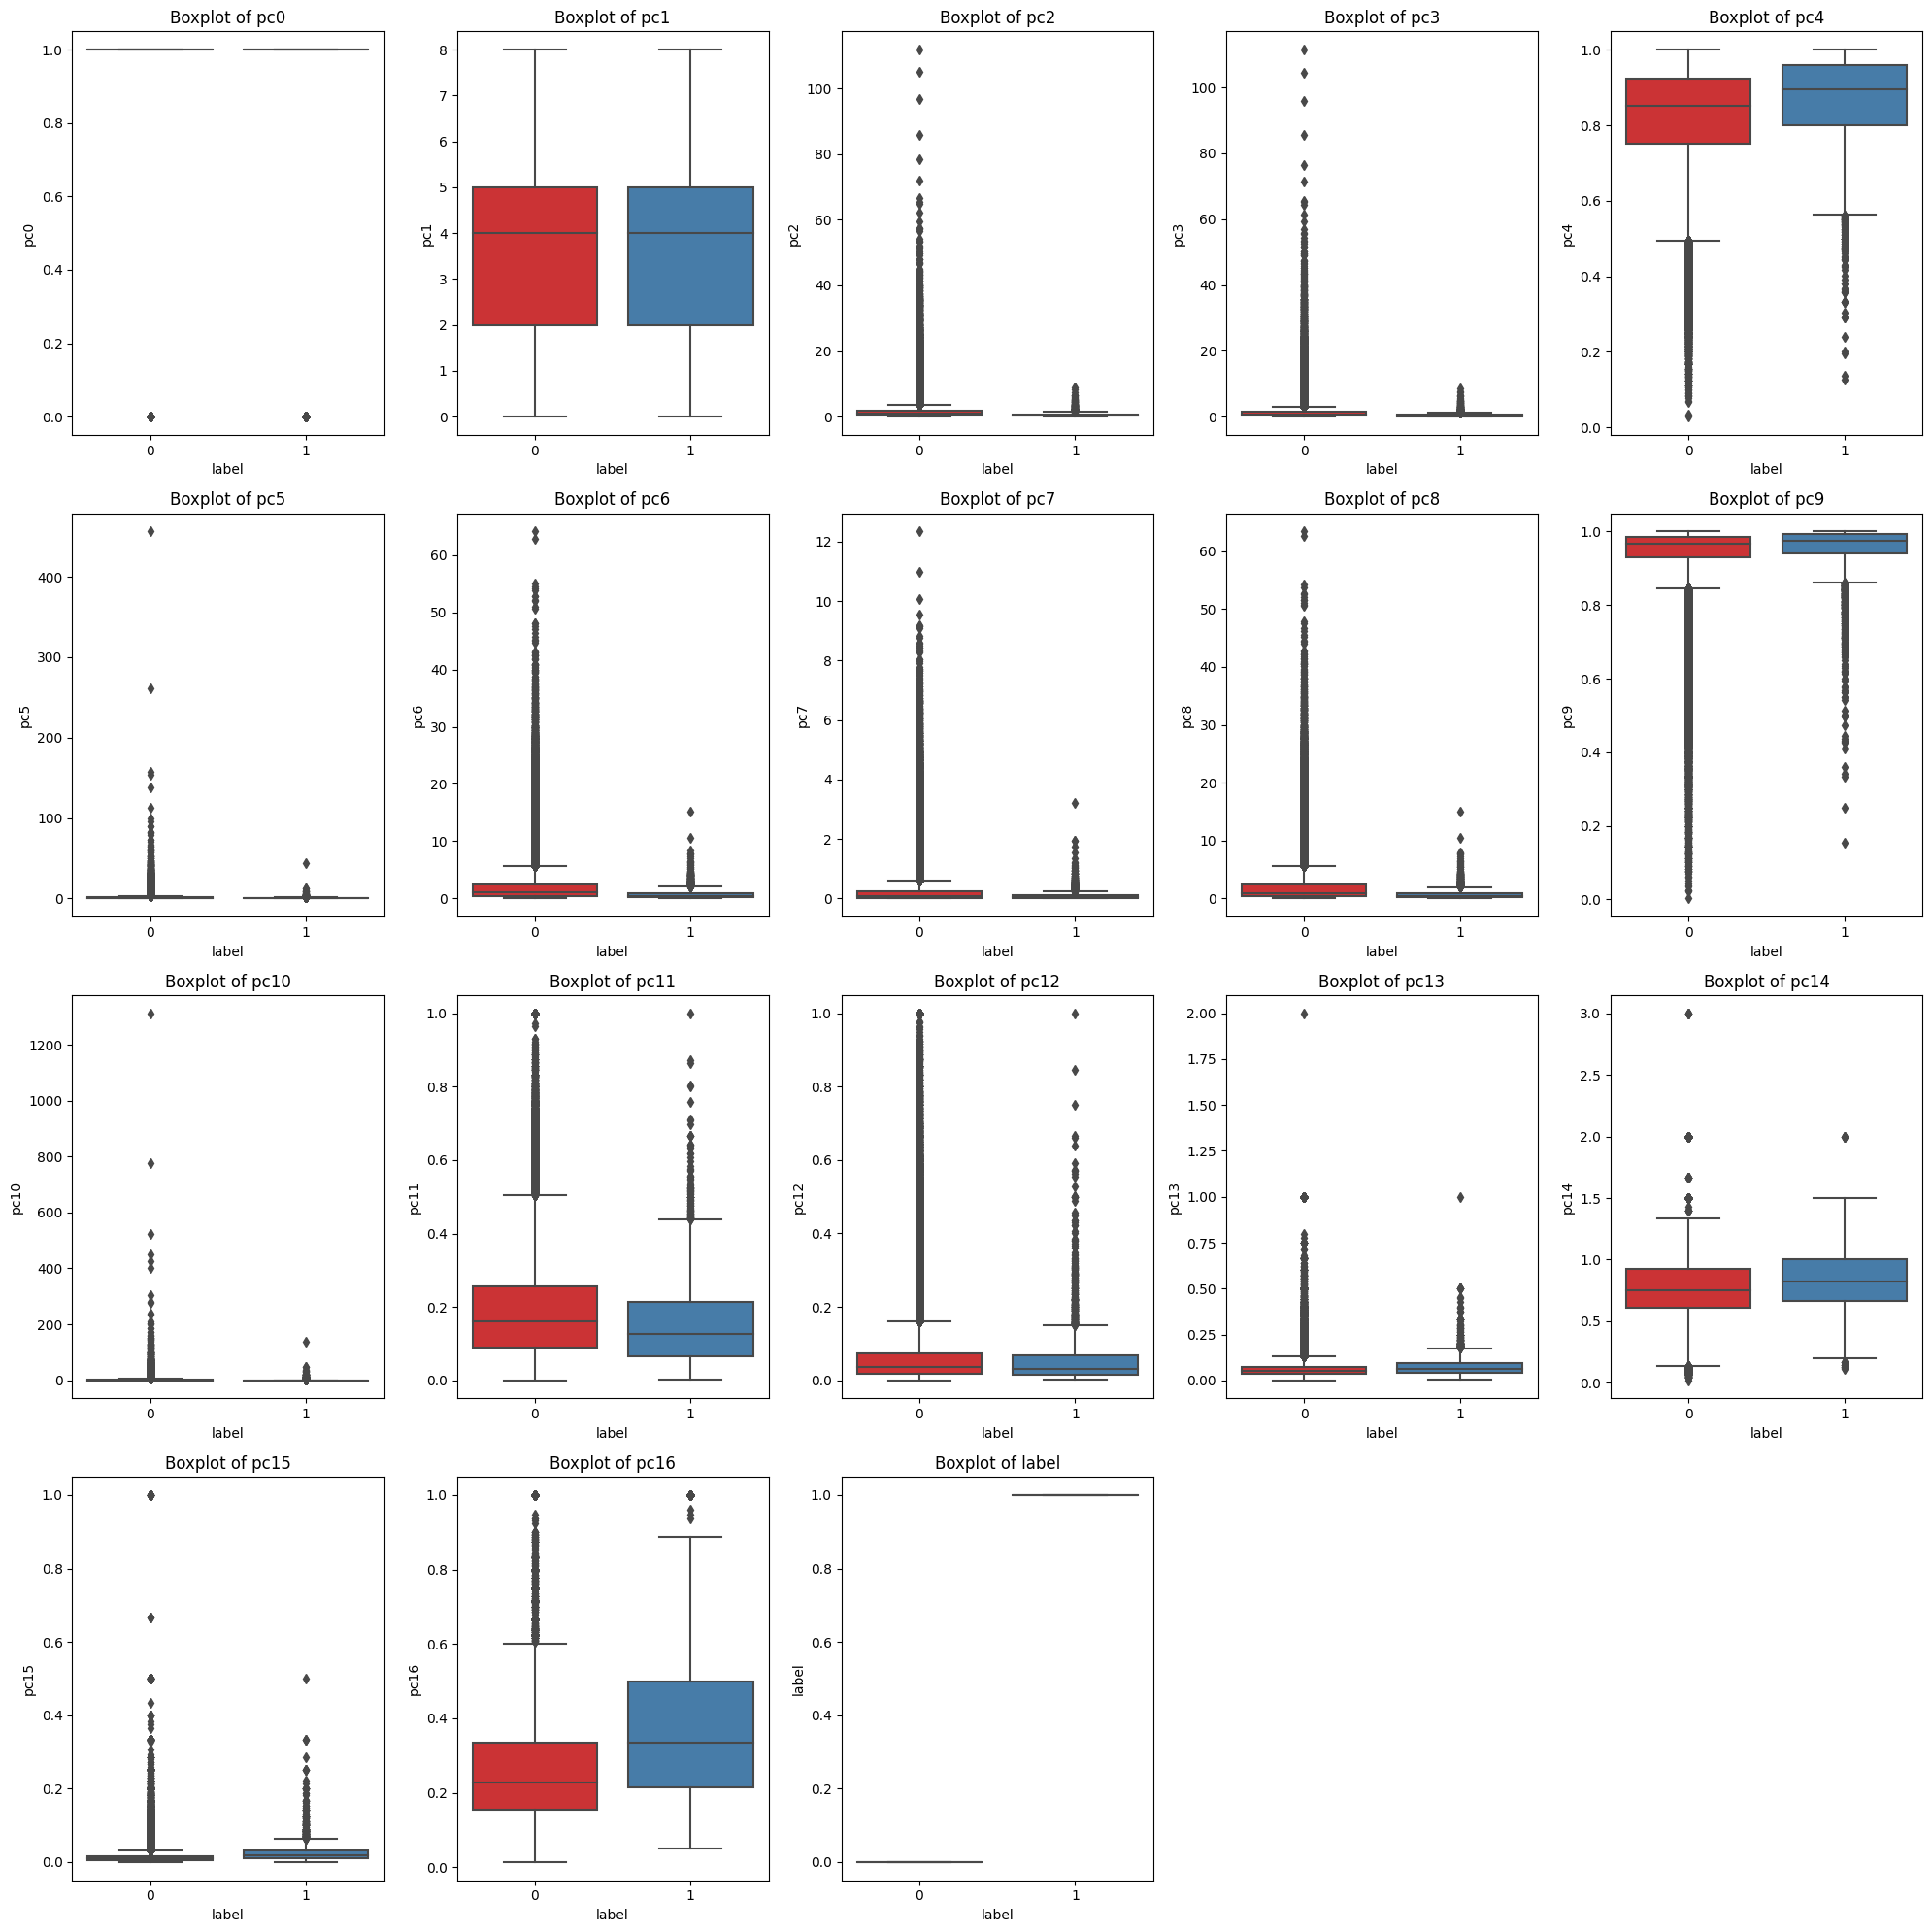

In [9]:
def boxplot_features(df, ncols=5):
    numeric_cols = df.select_dtypes(include=['int64', 'int32', 'float64', 'timedelta64[ns]']).columns
    n = len(numeric_cols)
    nrows = int(np.ceil(n / ncols))

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 5))
    axs = axs.flatten()

    for ax, column in zip(axs, numeric_cols):
        sns.boxplot(x='label', y=df[column], data=df, ax=ax, palette='Set1')
        ax.set_title(f'Boxplot of {column}')

    for i in range(len(numeric_cols), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

train_watch = train.drop('user_id', axis=1).copy()
boxplot_features(train_watch, ncols=5)

There are no abnormalities seen other than <span style="color:red">***outliers***</span> on some features. However these outliers will not be imputed because in fraud detection, outlier observations usually gives crucial information in classifying a fraud transaction.

- Assessing imbalanced label

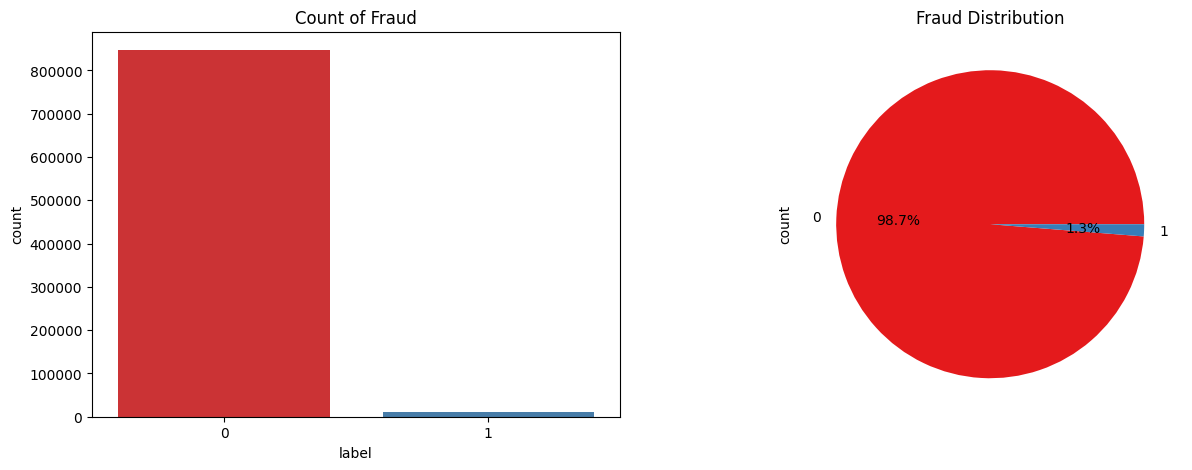

label
0    0.987345
1    0.012655
Name: proportion, dtype: float64


In [10]:
fig , ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='label', data=train, palette='Set1', ax=ax[0])
ax[0].set_title('Count of Fraud')

train['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1], colors=sns.color_palette('Set1'))
ax[1].set_title('Fraud Distribution')

plt.show()
print(train['label'].value_counts(1))


The dataset label is really imbalanced. Fraudulent labeled users are just 1% of the whole users in the train dataset.

### `test`

In [11]:
test

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,4,1.0,2.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,13,1.0,5.0,0.445,0.420,0.943820,0.8,0.783,0.234,0.778,0.993614,2.0,0.056180,0.006386,0.095238,0.750000,0.022472,0.250000
2,37,1.0,6.0,1.680,1.080,0.642857,0.6,1.167,0.046,1.007,0.862896,1.0,0.357143,0.137104,0.027778,0.500000,0.002976,0.166667
3,61,0.0,3.0,1.505,0.875,0.581395,0.9,0.425,0.012,0.286,0.672941,1.0,0.418605,0.327059,0.051429,0.333333,0.003322,0.111111
4,66,1.0,5.0,2.210,1.075,0.486425,1.0,1.349,0.087,1.015,0.752409,2.0,0.513575,0.247591,0.046512,0.800000,0.004525,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367697,3700510,1.0,1.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
367698,3700517,0.0,6.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
367699,3700526,0.0,1.0,0.220,0.195,0.886364,0.1,0.074,0.002,0.066,0.891892,0.0,0.113636,0.108108,0.025641,-1.000000,-1.000000,-1.000000
367700,3700539,1.0,4.0,2.440,2.295,0.940574,1.8,5.874,0.248,5.640,0.960163,7.0,0.059426,0.039837,0.039216,0.777778,0.014344,0.388889


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367702 entries, 0 to 367701
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  367702 non-null  int64  
 1   pc0      367702 non-null  float64
 2   pc1      367702 non-null  float64
 3   pc2      367702 non-null  float64
 4   pc3      367702 non-null  float64
 5   pc4      367702 non-null  float64
 6   pc5      367702 non-null  float64
 7   pc6      367702 non-null  float64
 8   pc7      367702 non-null  float64
 9   pc8      367702 non-null  float64
 10  pc9      367702 non-null  float64
 11  pc10     367702 non-null  float64
 12  pc11     367702 non-null  float64
 13  pc12     367702 non-null  float64
 14  pc13     367702 non-null  float64
 15  pc14     367702 non-null  float64
 16  pc15     367702 non-null  float64
 17  pc16     367702 non-null  float64
dtypes: float64(17), int64(1)
memory usage: 50.5 MB


The data types seems correct, there are no missing values seen because the data fills missing values with -1.

- Counting missing values

Replace -1 values to np.nan

In [13]:
test.iloc[:,1:18] = test.iloc[:,1:18].replace(-1, np.nan)

Percentage of missing values

In [14]:
test.isna().sum()/test.shape[0]*100

user_id     0.000000
pc0         0.206417
pc1         0.206417
pc2        35.696026
pc3        35.734372
pc4        35.734372
pc5        39.014474
pc6        35.696026
pc7        39.014474
pc8        35.734372
pc9        35.734372
pc10        0.000000
pc11       39.712321
pc12       39.712321
pc13       39.014746
pc14       41.241549
pc15       56.119358
pc16       56.119358
dtype: float64

The test data has a lot of missing values in most features.

- Assessing descriptive statistics

In [15]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,367702.0,1.846733e+06,1.068780e+06,4.000000,919444.500000,1.844812e+06,2.773638e+06,3700544.000
pc0,366943.0,7.496941e-01,4.331898e-01,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000
pc1,366943.0,3.717256e+00,1.925475e+00,0.000000,2.000000,4.000000e+00,5.000000e+00,8.000
pc2,236447.0,1.407587e+00,1.957618e+00,0.005000,0.405000,8.600000e-01,1.705000e+00,90.390
pc3,236306.0,1.168803e+00,1.791565e+00,0.005000,0.325000,6.850000e-01,1.370000e+00,90.160
pc4,236306.0,8.242904e-01,1.326247e-01,0.042857,0.751055,8.507463e-01,9.230769e-01,1.000
pc5,224245.0,1.159608e+00,1.771290e+00,0.100000,0.400000,7.000000e-01,1.400000e+00,120.200
pc6,236447.0,2.058619e+00,2.962687e+00,0.001000,0.358000,1.023000e+00,2.502000e+00,68.646
pc7,224245.0,2.352425e-01,4.548589e-01,0.001000,0.018000,7.400000e-02,2.490000e-01,12.679
pc8,236306.0,1.988872e+00,2.905871e+00,0.001000,0.331000,9.670000e-01,2.405000e+00,68.027


- Assessing distributions

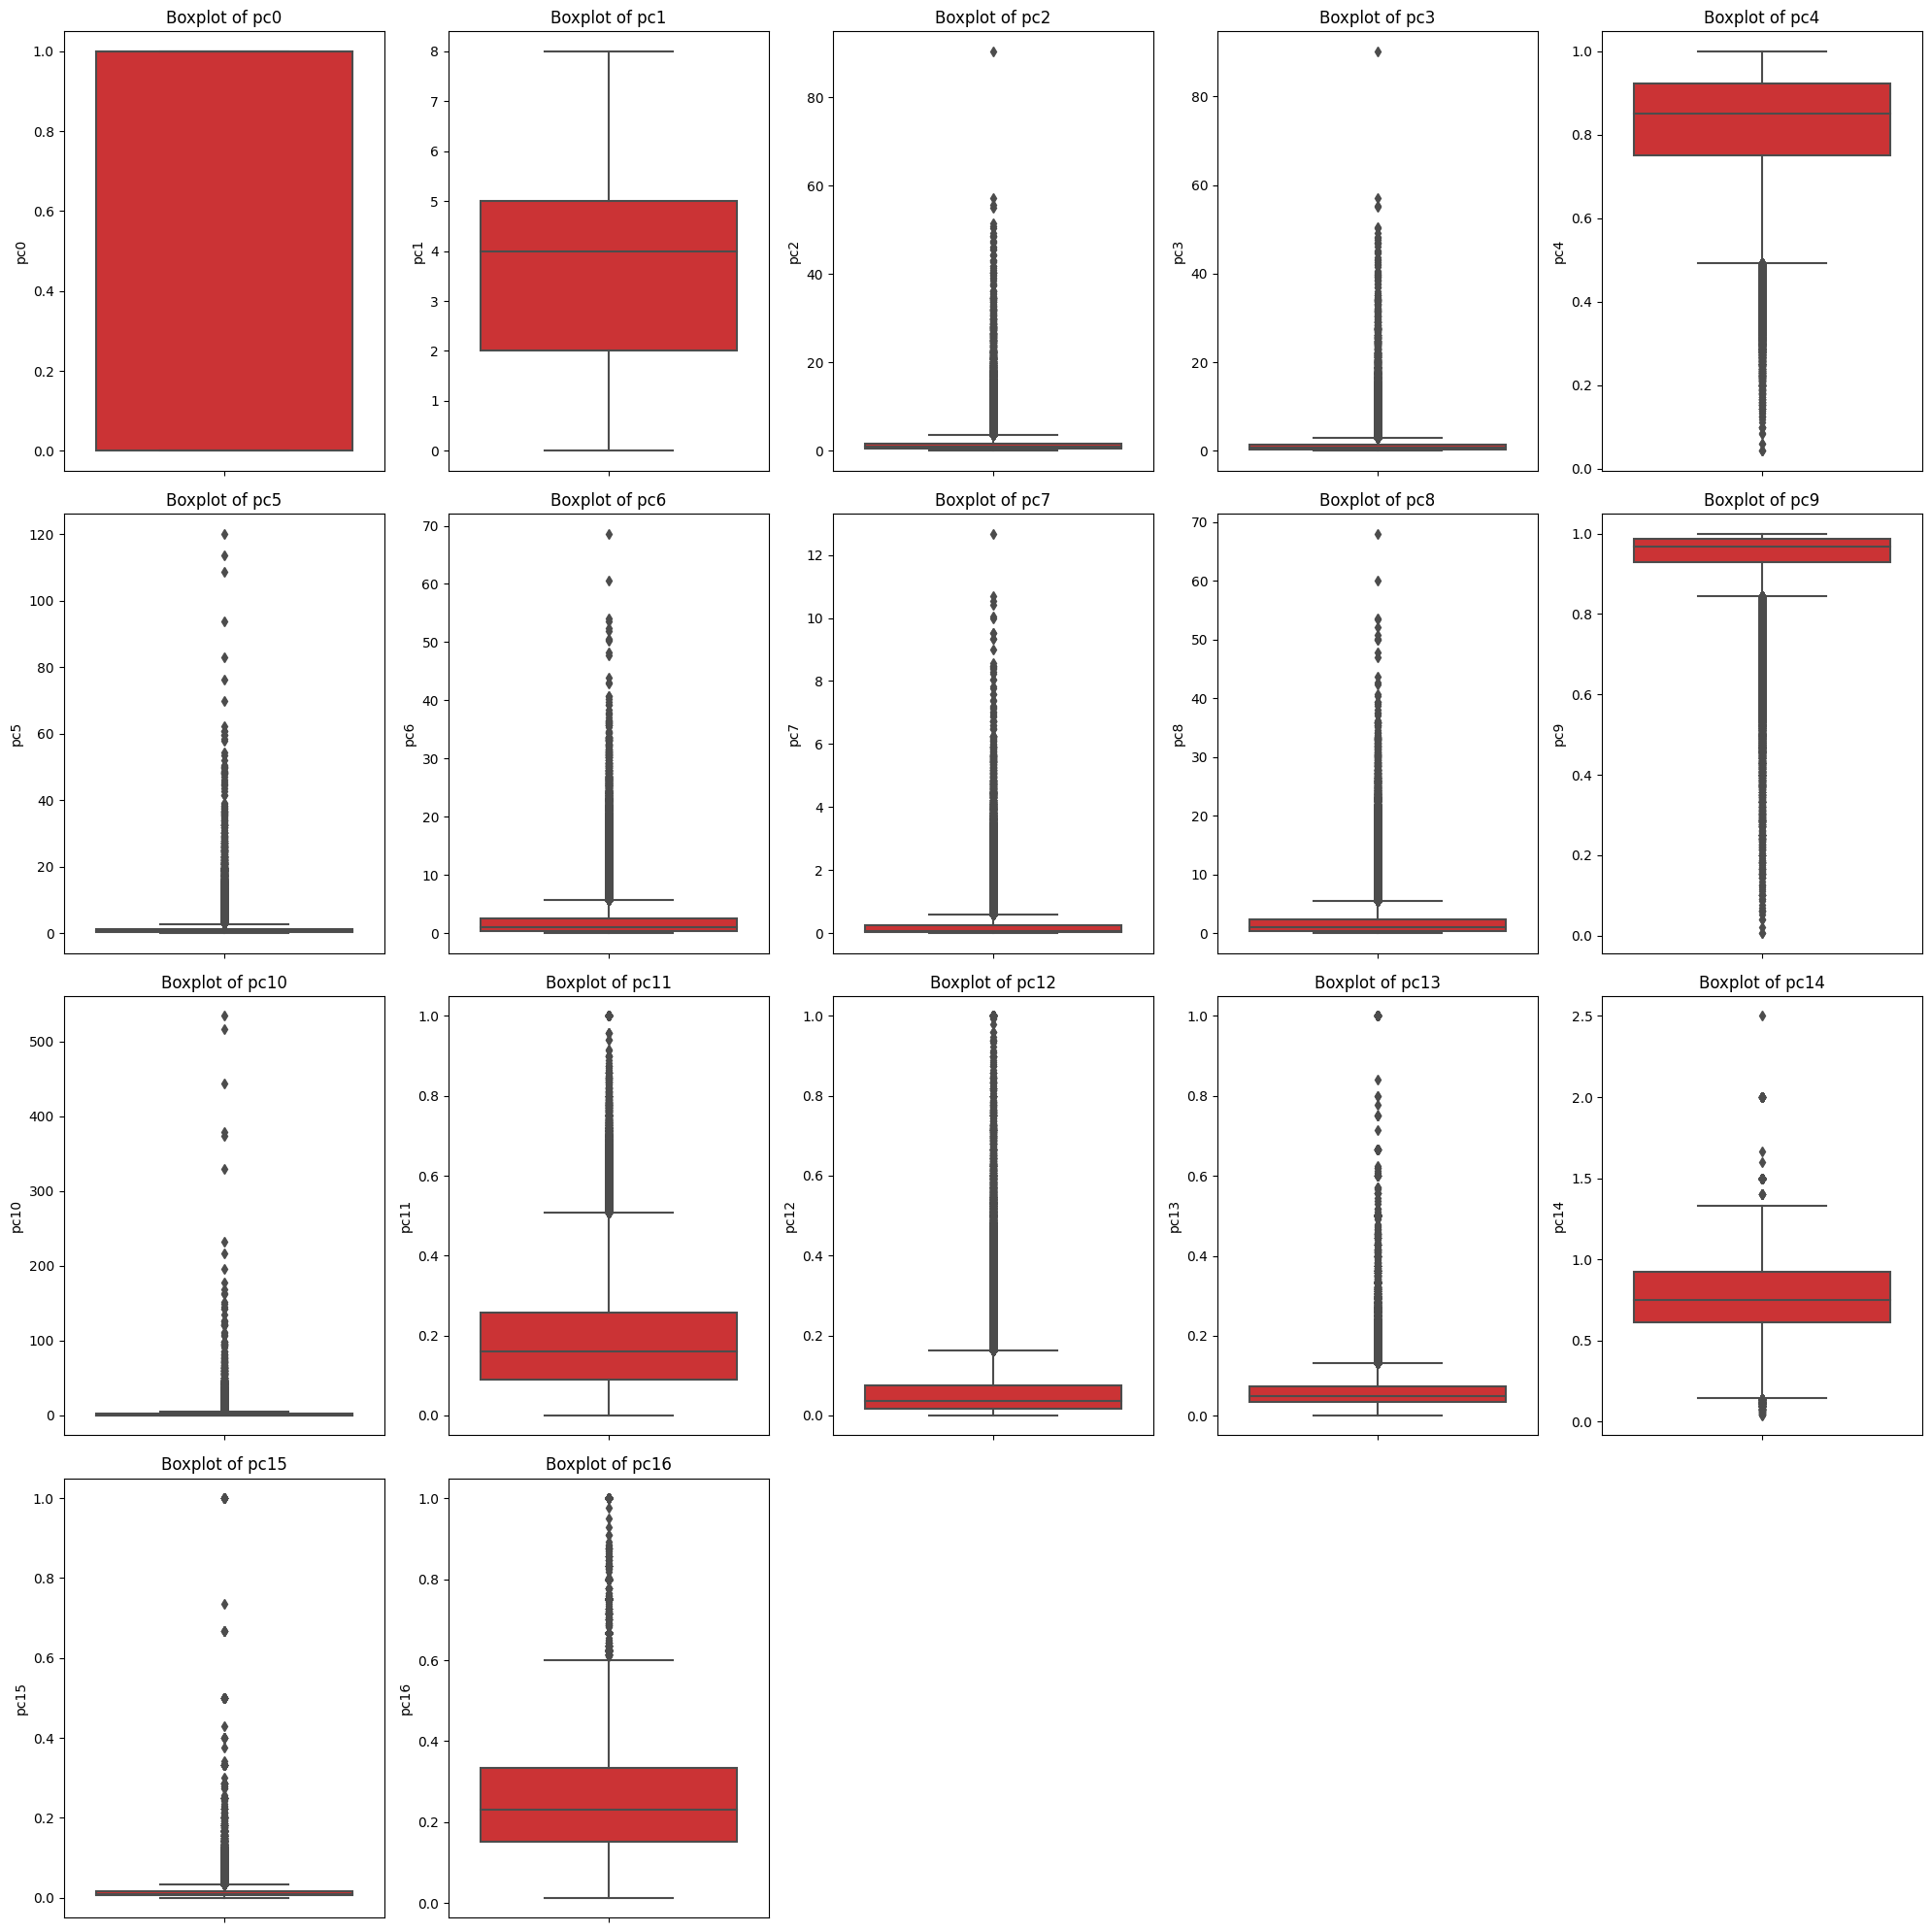

In [16]:
def boxplot_features2(df, ncols=5, label_col=None):
    numeric_cols = df.select_dtypes(include=['int64', 'int32', 'float64', 'timedelta64[ns]']).columns
    n = len(numeric_cols)
    nrows = int(np.ceil(n / ncols))

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 5))
    axs = axs.flatten()

    for ax, column in zip(axs, numeric_cols):
        if label_col:
            sns.boxplot(x=label_col, y=df[column], data=df, ax=ax, palette='Set1')
            ax.set_title(f'Boxplot of {column} by {label_col}')
        else:
            sns.boxplot(y=df[column], data=df, ax=ax, palette='Set1')
            ax.set_title(f'Boxplot of {column}')
            
    for i in range(len(numeric_cols), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

test_watch = test.drop('user_id', axis=1).copy()
boxplot_features2(test_watch, ncols=5)

Same as the `train` dataset, there are no abnormalities seen other than  <span style="color:red">***outliers***</span> on some features. However these outliers will not be imputed because in fraud detection, outlier observations usually gives crucial information in classifying a fraud transaction.

### `non_borrower_user`

In [17]:
non_borrower_user

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,0,1.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,1,0.0,8.0,0.630,0.565,0.896825,0.6,2.298,0.210,2.284,0.993908,1.0,0.103175,0.006092,0.053097,1.000000,0.007937,0.166667
2,2,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,6,0.0,1.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,7,1.0,6.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474944,3700542,1.0,7.0,0.540,0.485,0.898148,0.9,1.186,0.117,1.141,0.962057,2.0,0.101852,0.037943,0.092784,0.777778,0.018519,0.222222
2474945,3700545,1.0,7.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2474946,3700546,1.0,1.0,0.125,0.125,1.000000,-1.0,0.120,-1.000,0.120,1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2474947,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


- Checking the data types

In [18]:
non_borrower_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474949 entries, 0 to 2474948
Data columns (total 18 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  int64  
 1   pc0      float64
 2   pc1      float64
 3   pc2      float64
 4   pc3      float64
 5   pc4      float64
 6   pc5      float64
 7   pc6      float64
 8   pc7      float64
 9   pc8      float64
 10  pc9      float64
 11  pc10     float64
 12  pc11     float64
 13  pc12     float64
 14  pc13     float64
 15  pc14     float64
 16  pc15     float64
 17  pc16     float64
dtypes: float64(17), int64(1)
memory usage: 339.9 MB


The data types seems correct, there are no missing values seen because the data fills missing values with -1.

- Counting missing values

Replace -1 values to np.nan

In [19]:
non_borrower_user.iloc[:,1:18] = non_borrower_user.iloc[:,1:18].astype(np.float64).replace(-1, np.nan)

Percentage of missing values

In [20]:
non_borrower_user.isna().sum()/non_borrower_user.shape[0]*100

user_id     0.000000
pc0        21.909098
pc1        21.980897
pc2        63.360578
pc3        63.397064
pc4        63.397064
pc5        67.432824
pc6        63.360578
pc7        67.432824
pc8        63.397064
pc9        63.397064
pc10        0.000000
pc11       67.092090
pc12       67.092090
pc13       67.433026
pc14       69.416744
pc15       80.245492
pc16       80.245492
dtype: float64

Same as the other users dataset (`train` and `test`), this dataset has a lot of missing values in most features.

- Assessing descriptive statistics

In [21]:
non_borrower_user.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2474949.0,1.850468e+06,1.067903e+06,0.000000,925942.000000,1.850605e+06,2.774748e+06,3700549.000
pc0,1932710.0,7.791583e-01,4.148141e-01,0.000000,1.000000,1.000000e+00,1.000000e+00,1.000
pc1,1930933.0,3.825084e+00,2.330244e+00,0.000000,2.000000,4.000000e+00,5.000000e+00,8.000
pc2,906807.0,6.316457e-01,8.690279e-01,0.005000,0.200000,4.100000e-01,7.700000e-01,153.510
pc3,905904.0,5.525619e-01,8.140273e-01,0.005000,0.170000,3.500000e-01,6.650000e-01,153.375
pc4,905904.0,8.686703e-01,1.179834e-01,0.044776,0.812950,8.979592e-01,9.552239e-01,1.000
pc5,806021.0,6.588358e-01,9.218317e-01,0.100000,0.200000,4.000000e-01,8.000000e-01,231.200
pc6,906807.0,7.857050e-01,9.811999e-01,0.001000,0.171000,4.590000e-01,1.081000e+00,34.302
pc7,806021.0,9.326423e-02,1.738546e-01,0.001000,0.008000,3.200000e-02,1.030000e-01,7.132
pc8,905904.0,7.636111e-01,9.637002e-01,0.001000,0.161000,4.410000e-01,1.050000e+00,34.064


- Assessing distributions

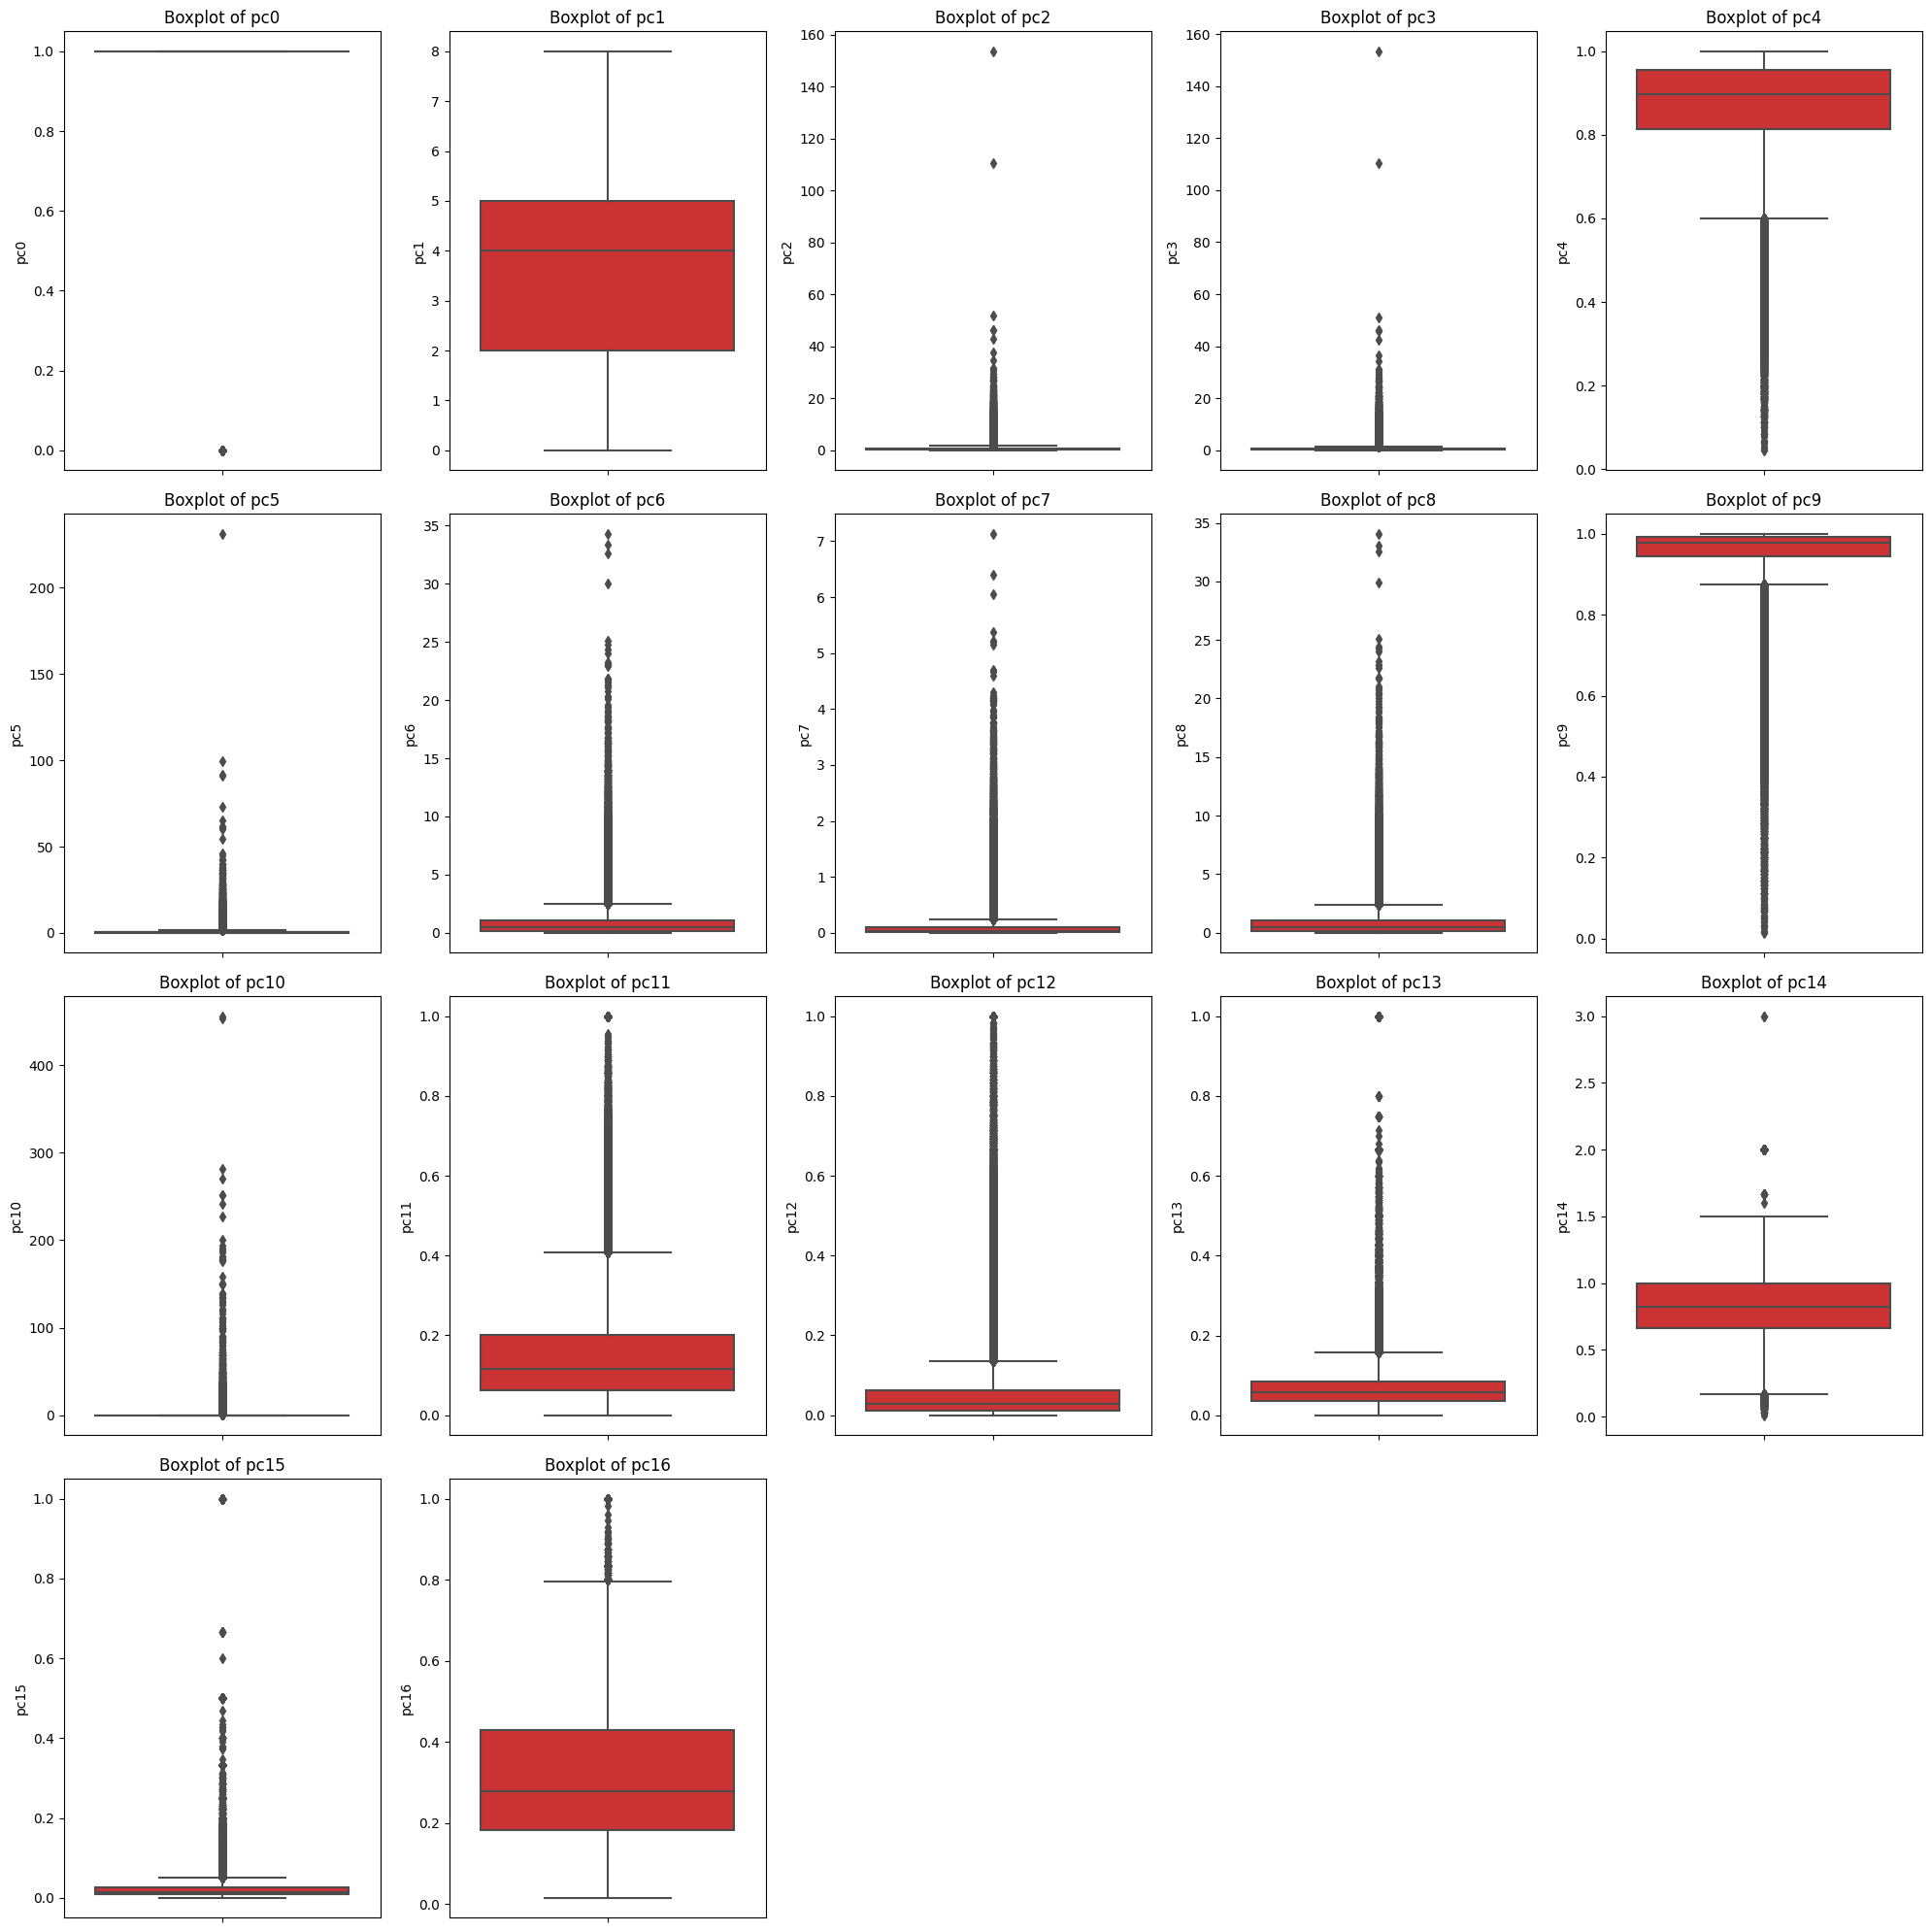

In [22]:
non_borrow_watch = non_borrower_user.drop('user_id', axis=1).copy()
boxplot_features2(non_borrow_watch, ncols=5)

Same as the `train` dataset, there are no abnormalities seen other than <span style="color:red">***outliers***</span> on some features. However these outliers will not be imputed because in fraud detection, outlier observations usually gives crucial information in classifying a fraud transaction.

### `loan_activities`

In [23]:
loan_activities

,user_id,reference_contact,loan_type,ts
0,2223129,903716,1,671
1,1380939,484583,1,89
2,2724411,1185034,1,230
3,2401751,1369254,1,120
4,1982168,21797,1,57
...,...,...,...,...
4300994,468400,2004356,11,493
4300995,2844279,1657495,11,609
4300996,1071963,2316823,11,1
4300997,2803447,3513529,11,367


- Checking the data types

In [24]:
loan_activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300999 entries, 0 to 4300998
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   user_id            int64
 1   reference_contact  int64
 2   loan_type          int64
 3   ts                 int64
dtypes: int64(4)
memory usage: 131.3 MB


The data types seems correct.

- Assessing descriptive statistics

In [25]:
loan_activities.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,4300999.0,1.850565e+06,1.068463e+06,1.0,924981.0,1849778.0,2776584.0,3700548.0
reference_contact,4300999.0,1.849301e+06,1.068566e+06,0.0,922903.5,1849514.0,2775051.5,3700549.0
loan_type,4300999.0,5.104953e+00,2.205495e+00,1.0,4.0,5.0,6.0,11.0
ts,4300999.0,4.093275e+02,2.222010e+02,1.0,226.0,412.0,582.0,821.0


- `loan_type` distribution

In [26]:
loan_activities['loan_type'].value_counts().sort_index()

loan_type
1      362904
2       51421
3      149977
4      911655
5     1604218
6      645389
7       15882
8       84338
9      125026
10     262515
11      87674
Name: count, dtype: int64

The distribution of `loan_type` are quite even.

## **Preprocessing & EDA**

Before conducting the analysis, it's important to fill in the missing values to ensure the results are meaningful and accurate. 

On this occasion, we won't use complex imputation methods like KNN Imputer; instead, we'll simply fill the missing values with the mean of each column.

In [27]:
datasets = [train, test, non_borrower_user]
example_columns = train.columns[1:18]  # Adjust as needed, but ensure columns remain consistent across all datasets.

columns_per_row = 4

for values in example_columns:
    print(f'Column: {values}')

    for df_name, df in zip(['Train Data', 'Test Data', 'Non Borrower User Data'], datasets):
        print(f'{df_name} Before Imputation:', end=" ")
        print(df[values].isna().sum(), end="  ")

    print()

    for df in datasets:
        combine_value = pd.concat([train.drop('label',axis=1), test, non_borrower_user], axis=0)
        df[values] = df[values].fillna(0)

    for df_name, df in zip(['Train Data', 'Test Data', 'Non Borrower User Data'], datasets):
        print(f'{df_name} After Imputation:', end=" ")
        print(df[values].isna().sum(), end="  ")

    print("\n" + "-" * 130)

    if (list(example_columns).index(values) + 1) % columns_per_row == 0:
        print()


Column: pc0
Train Data Before Imputation: 1773  Test Data Before Imputation: 759  Non Borrower User Data Before Imputation: 542239  
Train Data After Imputation: 0  Test Data After Imputation: 0  Non Borrower User Data After Imputation: 0  
----------------------------------------------------------------------------------------------------------------------------------
Column: pc1
Train Data Before Imputation: 1774  Test Data Before Imputation: 759  Non Borrower User Data Before Imputation: 544016  
Train Data After Imputation: 0  Test Data After Imputation: 0  Non Borrower User Data After Imputation: 0  
----------------------------------------------------------------------------------------------------------------------------------
Column: pc2
Train Data Before Imputation: 305125  Test Data Before Imputation: 131255  Non Borrower User Data Before Imputation: 1568142  
Train Data After Imputation: 0  Test Data After Imputation: 0  Non Borrower User Data After Imputation: 0  
---------

In [28]:
train.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,0.951782,1.0,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0
3,10,0.0,5.0,0.000,0.000,0.000000,0.0,0.000,0.000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,17,1.0,1.0,0.235,0.160,0.680851,0.1,0.120,0.002,0.104,0.866667,0.0,0.319149,0.133333,0.031250,0.000000,0.000000,0.000000,0


In [29]:
test.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,4,1.0,2.0,0.000,0.000,0.000000,0.0,0.000,0.000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,13,1.0,5.0,0.445,0.420,0.943820,0.8,0.783,0.234,0.778,0.993614,2.0,0.056180,0.006386,0.095238,0.750000,0.022472,0.250000
2,37,1.0,6.0,1.680,1.080,0.642857,0.6,1.167,0.046,1.007,0.862896,1.0,0.357143,0.137104,0.027778,0.500000,0.002976,0.166667
3,61,0.0,3.0,1.505,0.875,0.581395,0.9,0.425,0.012,0.286,0.672941,1.0,0.418605,0.327059,0.051429,0.333333,0.003322,0.111111
4,66,1.0,5.0,2.210,1.075,0.486425,1.0,1.349,0.087,1.015,0.752409,2.0,0.513575,0.247591,0.046512,0.800000,0.004525,0.200000


In [30]:
non_borrower_user.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,0,1.0,5.0,0.00,0.000,0.000000,0.0,0.000,0.00,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,1,0.0,8.0,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,0.993908,1.0,0.103175,0.006092,0.053097,1.0,0.007937,0.166667
2,2,0.0,0.0,0.00,0.000,0.000000,0.0,0.000,0.00,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,6,0.0,1.0,0.00,0.000,0.000000,0.0,0.000,0.00,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,7,1.0,6.0,0.00,0.000,0.000000,0.0,0.000,0.00,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


- Creating the complete user dataset

In [31]:
combined = pd.concat([train.drop(columns=['label']).set_index('user_id'), 
                      test.set_index('user_id'), 
                      non_borrower_user.set_index('user_id')], axis=0).sort_index()

In [32]:
combined.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
user_id,,,,,,,,,,,,,,,,,
0,1.0,5.0,0.000,0.000,0.000000,0.0,0.000,0.00,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,0.0,8.0,0.630,0.565,0.896825,0.6,2.298,0.21,2.284,0.993908,1.0,0.103175,0.006092,0.053097,1.00,0.007937,0.166667
2,0.0,0.0,0.000,0.000,0.000000,0.0,0.000,0.00,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.04,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.75,0.018182,0.250000
4,1.0,2.0,0.000,0.000,0.000000,0.0,0.000,0.00,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000


### **Corelation Heatmap**

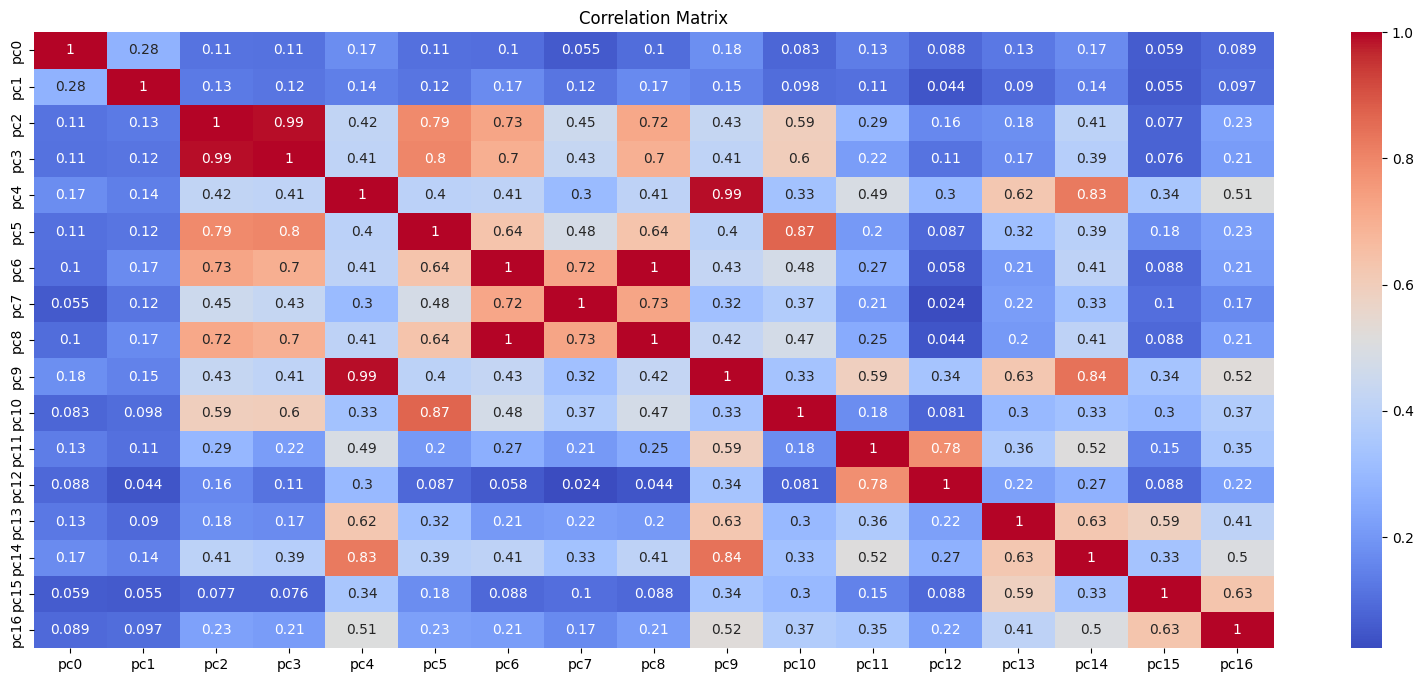

In [33]:
plt.figure(figsize=(20, 8)) 
corr_matrix = combined.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The correlation heatmap of PC features (pc0 to pc16) in the combined dataset above illustrates the relationships between these PC features. Correlation is measured on a scale from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation. The heatmap reveals that some features are highly correlated, such as pc12 and pc9 with a correlation of -0.91, pc11 and pc9 with a correlation of -0.67, pc3 and pc2 with a correlation of 0.99, and pc3 and pc5 with a correlation of 0.75, among others. This indicates that these features have a strong relationship and tend to move together. On the other hand, pc0 shows very low correlation with other features, with the highest value being around -0.05 with pc1, suggesting that pc0 might be an independent component with little influence from other features. High positive correlation between certain features suggests that they may carry similar information, while low or negative correlations indicate more diverse information.

### **Graph Analysis**

![Example Image](/Users/mraffyzeidan/Documents/Code/Ristek-UI-Competition-2024/image/Fig1.png)

`Static graphs`, `discrete dynamic graphs`, and `temporal graphs`. Static graphs have only one whole time, which can be considered as the final moment. Discrete dynamic graphs intercept the current state of the graph at equal intervals to generate a static snapshot of the corresponding moment. Temporal graphs record the time of each node interaction, which is continuous in a realistic sense, and are also known as continuous-time dynamic graphs (Liu et al., 2023).

Reference List:
Liu, M., Liang, K., Zhao, Y., Tu, W., Zhou, S., Gan, X., & Liu, X. (2023). Self-supervised temporal graph learning with temporal and structural intensity alignment. *IEEE Transactions on Neural Networks and Learning Systems*, 1.



#### **Graph Data**

In [34]:
loan_activities

,user_id,reference_contact,loan_type,ts
0,2223129,903716,1,671
1,1380939,484583,1,89
2,2724411,1185034,1,230
3,2401751,1369254,1,120
4,1982168,21797,1,57
...,...,...,...,...
4300994,468400,2004356,11,493
4300995,2844279,1657495,11,609
4300996,1071963,2316823,11,1
4300997,2803447,3513529,11,367


We can ensure that the timestamps we have are of discrete time type.

Now , we will se the `Graph Structure` that we have

In [35]:
time_points = sorted(loan_activities['ts'].unique())

# Example print relationships for the first 3 timestamps
for time_step in time_points[:3]:
    subset = loan_activities[loan_activities['ts'] == time_step]
    num_edges = len(subset)
    print(f'Timestamp: {time_step}, Number of edges: {num_edges}')
    print('Edge indices:')
    print(np.array([subset['user_id'].values, subset['reference_contact'].values]))
    print()

Timestamp: 1, Number of edges: 4604
Edge indices:
[[1010509 2508597 1654964 ... 2160623 1243759 1071963]
 [   9280 3550595 1883859 ... 3391562 1229606 2316823]]

Timestamp: 2, Number of edges: 4638
Edge indices:
[[ 362949 2064524 2360074 ... 3328391 1828987  698156]
 [2798089 1915744 3242447 ... 2636562  493798 1224898]]

Timestamp: 3, Number of edges: 4581
Edge indices:
[[2366379   71882   62490 ... 1377947  863221  162487]
 [2048171 3445247  804132 ... 2920236 2089015 1245373]]



The data above shows the number of edges and the specific relationships at three different timestamps.

- **Dynamic Nature**: The change in the number of edges and the variation in edge indices at different timestamps indicate that the network is dynamic. For instance, the edge indices for Timestamp 1 differ from those for Timestamp 2 and 3. This variation suggests that the relationships between users and reference contacts are not static and evolve over time.

- **Evidence of Change**: The differences in edge indices across timestamps provide concrete evidence that user interactions and relationships vary over time. This dynamic nature is crucial for understanding the temporal aspects of the dataset and for modeling dynamic interactions accurately.

### Summary:

1. There is a highly complex relationship between nodes at a given timestamp.
2. A significant amount of computation is required to understand the patterns between nodes at a given timestamp.

This complexity necessitates careful consideration when choosing the computational approach for making future predictions.

### Possible Solutions:

| **Solution** | **Pros** | **Cons** |
|--------------|----------|----------|
| 1. Implementing LSTM/GRU in the computational loop for Dynamic Graph Data at each timestamp. | Can retain and detect patterns that relate to previous time steps (t-1) and the current time (t). | Computation using LSTM/GRU is resource-intensive and can consume a lot of memory. A substantial amount of GPU memory is also required for this computation. |
| 2. Using Alternative Temporal Graph Datasets for simpler/lighter computation. | Provides highly efficient computation without requiring extensive GPU memory. | May lack the ability to capture information about relationships between nodes over time. |


Given the large volume of data, we prefer using a Temporal Graph Dataset without GRU/LSTM Method to minimize computational costs.


## **Graph Neural Network**

### **Feature Engineering**

based on Graph Stucture

### Aggregating Community Features for Nodes

In this section, we focus on deriving two main aggregated features from community detection in a dynamic graph:

1. **Majority Community Assignment:**
   - This feature identifies the most frequently assigned community for each `user_id` across all timestamps. It represents the dominant community for the node over time.

2. **Number of Unique Communities:**
   - This feature counts the number of distinct communities each `user_id` is associated with across all timestamps. It indicates the diversity of the node's community interactions.


In [38]:
community_tracking = {}

for time_step in tqdm(time_points, desc="Processing time steps"):
    subset = loan_activities[loan_activities['ts'] == time_step]
    
    G = nx.Graph()
    edges = np.array([subset['user_id'].values, subset['reference_contact'].values])
    G.add_edges_from(zip(edges[0], edges[1]))
    
    partition = community_louvain.best_partition(G)
    
    for user_id, community_id in partition.items():
        if user_id not in community_tracking:
            community_tracking[user_id] = {}
        community_tracking[user_id][time_step] = community_id

def majority_community(user_id):
    communities = [community_tracking.get(user_id, {}).get(ts, np.nan) for ts in time_points]
    return Counter(filter(pd.notna, communities)).most_common(1)[0][0] if communities else np.nan

combined['majority_community'] = [majority_community(user_id) for user_id in tqdm(combined.index, desc="Calculating Majority Community")]

combined['num_unique_communities'] = [len(set(community_tracking.get(user_id, {}).values())) for user_id in tqdm(combined.index, desc="Calculating Number of Unique Communities")]

Calculating Number of Unique Communities: 100%|██████████| 3700550/3700550 [00:08<00:00, 454626.05it/s]


### Summary

The `combined` DataFrame now includes:
- **`majority_community`**: The predominant community each `user_id` belongs to across all timestamps.
- **`num_unique_communities`**: The count of unique communities associated with each `user_id` over the selected time points.

These aggregated features offer a compact representation of node behavior without the need for numerous columns, providing a clearer view of the community dynamics.


### **Creating The Dataset Structure**

In [39]:
events = TemporalData(
    src=torch.tensor(np.array(loan_activities.user_id.values), dtype=torch.long),
    dst=torch.tensor(np.array(loan_activities.reference_contact.values), dtype=torch.long),
    t=torch.tensor(np.array(loan_activities.ts.values), dtype=torch.long),
    msg=torch.tensor(np.array(loan_activities.loan_type.values), dtype=torch.long)
)

print(events)

TemporalData(src=[4300999], dst=[4300999], t=[4300999], msg=[4300999])


### Node Feature Normalization and Label Preparation

In this section, we perform two key preprocessing steps for our node features and labels: normalization and label preparation.


In [40]:
train = train.set_index('user_id')
test = test.set_index('user_id')

In [86]:
node_features = torch.tensor(np.array(combined.values), dtype=torch.float)

# Normalize node features (z-score normalization)
mean = node_features.mean(dim=0, keepdim=True)
std = node_features.std(dim=0, keepdim=True)
node_features = (node_features - mean) / std

node_labels = torch.tensor(train['label'].reindex(combined.index).fillna(-1).values, dtype=torch.long)
labels = train['label']

### Data Splitting and GPU Preparation

This section shows how to split the dataset into training, validation, and test sets, create masks for these splits, and prepare data for GPU acceleration.

1. **Stratified Data Splitting** ensures that the distribution of labels is consistent across training and validation sets, using a stratified split to maintain proportional representation of each class.

2. **Mask Creation** involves creating boolean masks to separate nodes into training, validation, and test sets. These masks are updated based on the indices of the respective data splits.

3. **GPU Preparation** optimizes performance by pinning memory and moving data to the GPU. This step reduces the time spent on data transfer during model training and inference.


In [87]:
train_ids, val_ids = train_test_split(train.index, test_size=0.2, stratify=labels, random_state=42)

num_nodes = node_features.size(0)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[combined.index.isin(train_ids)] = True
val_mask[combined.index.isin(val_ids)] = True
test_mask[combined.index.isin(test.index)] = True

node_features = node_features.pin_memory().to('cuda:0', non_blocking=True)
node_labels = node_labels.pin_memory().to('cuda:0', non_blocking=True)
train_mask = train_mask.pin_memory().to('cuda:0', non_blocking=True)
test_mask = test_mask.pin_memory().to('cuda:0', non_blocking=True)

## Node Classification Models

This document provides an overview of two types of models designed for node classification tasks: `GraphSAGENodeClassifier`.

### GraphSAGE Model

The GraphSAGE (Graph Sample and Aggregation) model is designed to learn node embeddings by aggregating information from a node's local neighborhood. It effectively samples and combines features from neighboring nodes to generate meaningful embeddings for each node.

- **Strengths:** 
  - Can handle large graphs by sampling and aggregating local information.



In [88]:
class GraphSAGENodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphSAGENodeClassifier, self).__init__()
        self.conv1 = SAGEConv(in_channels,128)
        self.conv2 = SAGEConv(128, 32)
        self.fc1 = torch.nn.Linear(32, 20)
        self.fc2 = torch.nn.Linear(20, out_channels)
        self.dropout = torch.nn.Dropout(p=0.32)

    def forward(self, events, node_features):
        x = F.relu(self.conv1(node_features, events.edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, events.edge_index))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [89]:
class_weights = torch.Tensor([1, 55]).to('cuda:0')

models = {
    'GraphSAGE': GraphSAGENodeClassifier(node_features.size(1), 2).to('cuda:0')
}

optimizers = {
    'GraphSAGE': torch.optim.Adam(models['GraphSAGE'].parameters(), lr=0.0051)
}

criterions = {
    'GraphSAGE': torch.nn.CrossEntropyLoss(weight=class_weights)
}

metrics = {
    'GraphSAGE': {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_ap': []}
}

In [90]:
patience = 50
epochs = 200

for model_name, model in models.items():
    print(f"Training {model_name} model...")

    events = events.to('cuda:0')
    node_features = node_features.to('cuda:0')

    optimizer = optimizers[model_name]
    criterion = criterions[model_name]

    best_val_ap = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(events, node_features)
        loss = criterion(out[train_mask], node_labels[train_mask].long())
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            prob = F.softmax(out, dim=1)[:, 1]
            pred = prob[val_mask] >= 0.5
            correct_val = int(pred.eq(node_labels[val_mask]).sum().item())
            acc_val = correct_val / int(val_mask.sum())
            ap_score = average_precision_score(node_labels[val_mask].cpu().numpy(), prob[val_mask].cpu().numpy())

            train_acc = (out[train_mask].argmax(dim=1) == node_labels[train_mask]).float().mean().item()
            train_loss = loss.item()

            metrics[model_name]['train_loss'].append(train_loss)
            metrics[model_name]['train_acc'].append(train_acc)
            metrics[model_name]['val_acc'].append(acc_val)
            metrics[model_name]['val_ap'].append(ap_score)

        print(f'{model_name} Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {acc_val:.4f}, Val AP: {ap_score:.4f}')

        if ap_score > best_val_ap:
            best_val_ap = ap_score
            patience_counter = 0
            torch.save(model.state_dict(), f'{model_name}_Model.pth') 
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"{model_name} Early stopping")
                break

  
    model.load_state_dict(torch.load(f'{model_name}_Model.pth'))

    # Clear GPU memory
    del model
    torch.cuda.empty_cache()

Training GraphSAGE model...
GraphSAGE Epoch: 000, Loss: 0.7069, Train Acc: 0.1253, Val Acc: 0.1259, Val AP: 0.0131
GraphSAGE Epoch: 001, Loss: 0.6746, Train Acc: 0.6594, Val Acc: 0.6613, Val AP: 0.0160
GraphSAGE Epoch: 002, Loss: 0.6540, Train Acc: 0.8382, Val Acc: 0.8395, Val AP: 0.0184
GraphSAGE Epoch: 003, Loss: 0.6326, Train Acc: 0.8266, Val Acc: 0.8252, Val AP: 0.0223
GraphSAGE Epoch: 004, Loss: 0.6173, Train Acc: 0.7641, Val Acc: 0.7643, Val AP: 0.0243
GraphSAGE Epoch: 005, Loss: 0.6086, Train Acc: 0.7025, Val Acc: 0.7046, Val AP: 0.0264
GraphSAGE Epoch: 006, Loss: 0.6039, Train Acc: 0.6668, Val Acc: 0.6687, Val AP: 0.0260
GraphSAGE Epoch: 007, Loss: 0.5982, Train Acc: 0.6459, Val Acc: 0.6460, Val AP: 0.0272
GraphSAGE Epoch: 008, Loss: 0.5933, Train Acc: 0.6329, Val Acc: 0.6348, Val AP: 0.0277
GraphSAGE Epoch: 009, Loss: 0.5862, Train Acc: 0.6238, Val Acc: 0.6250, Val AP: 0.0286
GraphSAGE Epoch: 010, Loss: 0.5830, Train Acc: 0.6204, Val Acc: 0.6211, Val AP: 0.0301
GraphSAGE Epoch

       Model  Epoch        Type     Value
0  GraphSAGE      0  Train Loss  0.706922
1  GraphSAGE      1  Train Loss  0.674646
2  GraphSAGE      2  Train Loss  0.653991
3  GraphSAGE      3  Train Loss  0.632591
4  GraphSAGE      4  Train Loss  0.617260


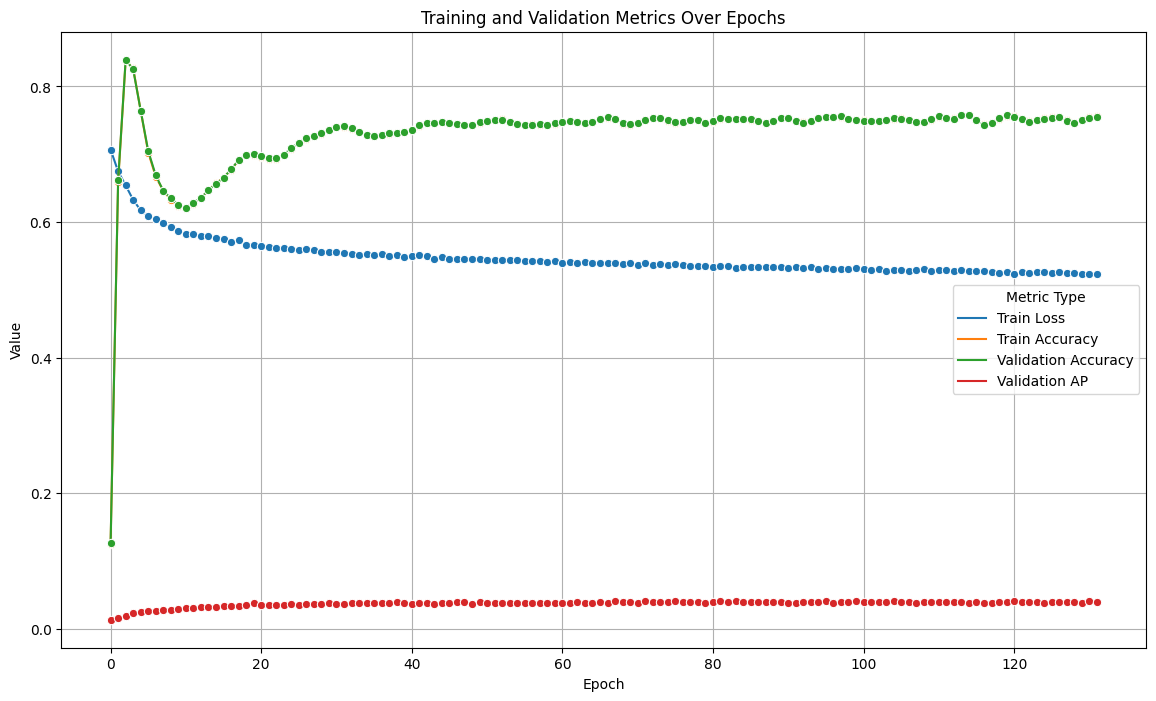

In [91]:
plot_data = []
model_name = 'GraphSAGE'
metric_values = metrics[model_name]
epochs_range = list(range(len(metric_values['train_acc'])))

plot_data.extend([
    {'Model': model_name, 'Epoch': epoch, 'Type': 'Train Loss', 'Value': loss}
    for epoch, loss in zip(epochs_range, metric_values['train_loss'])
])
plot_data.extend([
    {'Model': model_name, 'Epoch': epoch, 'Type': 'Train Accuracy', 'Value': acc}
    for epoch, acc in zip(epochs_range, metric_values['train_acc'])
])
plot_data.extend([
    {'Model': model_name, 'Epoch': epoch, 'Type': 'Validation Accuracy', 'Value': val_acc}
    for epoch, val_acc in zip(epochs_range, metric_values['val_acc'])
])
plot_data.extend([
    {'Model': model_name, 'Epoch': epoch, 'Type': 'Validation AP', 'Value': val_ap}
    for epoch, val_ap in zip(epochs_range, metric_values['val_ap'])
])

df = pd.DataFrame(plot_data)
print(df.head()) 

plt.figure(figsize=(14, 8))

sns.lineplot(data=df, x='Epoch', y='Value', hue='Type', marker='o')

plt.title('Training and Validation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(title='Metric Type')
plt.grid(True)

plt.show()

From the visualization results above, it can be concluded that GraphSAGE performs well on the data. The average precision score is also nearly comparable to that reported in previous studies (reference).

Conclusion:
Although using a temporal dataset and not employing a Dynamic Graph Dataset, we were still able to achieve results similar to those of previous research. However, if I may suggest, having a clearer understanding of the variables would be beneficial for researching and analyzing the patterns of relationships among these variables. It is also assured that the graph structure used in this case can provide better information for future predictions. I also hope that future computations can leverage more advanced graphs utilizing large-scale GPUs. In the next phase, we will proceed with predictions on the test data.

### **Predicting**

In [92]:
model = GraphSAGENodeClassifier(node_features.size(1), 2).to('cuda:0')
model.load_state_dict(torch.load('GraphSAGE_Model.pth'))
model.eval()

with torch.no_grad():
    prob = F.softmax(model(events, node_features), dim=1)[:, 1]
    test_prob = prob[test_mask].cpu().numpy()

submission = pd.DataFrame({'user_id':test.index, 'label':test_prob})

In [93]:
submission

,user_id,label
0,4,0.653069
1,13,0.557930
2,37,0.057087
3,61,0.135568
4,66,0.012994
...,...,...
367697,3700510,0.419126
367698,3700517,0.131004
367699,3700526,0.332719
367700,3700539,0.020243


In [95]:
submission.to_csv('Submission-Final.csv', index=False)

![Example Image](/Users/mraffyzeidan/Documents/Code/Ristek-UI-Competition-2024/image/Fig2.png)